In [1]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import os, sys, fnmatch
import numpy as np
from lxml import etree
import hashlib, json
import re
import pandas as pd
import pickle
from tqdm import tqdm_notebook
from sklearn.metrics import f1_score

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

In [3]:
with open('./public_bouy_data.pkl', 'rb') as f:
    data = pickle.load(f)

In [4]:
with open('./public_bouy_target.pkl', 'rb') as f:
    targets = pickle.load(f)

In [5]:
history_length = 30
forecast_range = 1

In [6]:
with open('./x_AR_vectorized.pkl', 'rb') as f:
    x_AR_vectorized = pickle.load(f)

In [7]:
with open('./y_AR_vectorized.pkl', 'rb') as f:
    y_AR_vectorized = pickle.load(f)

In [8]:
with open('./x_AR_vectorized_concat.pkl', 'rb') as f:
    x_AR_vectorized_train = pickle.load(f)

In [9]:
with open('./y_AR_vectorized_concat.pkl', 'rb') as f:
    y_AR_vectorized_train = pickle.load(f)

In [10]:
x_AR_vectorized_train.shape

(233282, 90)

In [11]:
y_AR_vectorized_train.shape

(233282, 3)

In [12]:
m = RandomForestRegressor(n_jobs=20, verbose=2)

In [13]:
m.fit(x_AR_vectorized_train, y_AR_vectorized_train)

[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.


building tree 1 of 100building tree 2 of 100

building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:   29.2s


building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64

[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:  2.6min finished


RandomForestRegressor(n_jobs=20, verbose=2)

In [14]:
yAR_approx = m.predict(x_AR_vectorized_train)

[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:    1.6s finished


In [15]:
yAR_approx.shape

(233282, 3)

In [16]:
rse = np.square(yAR_approx-y_AR_vectorized_train).sum(axis=1)
rse.shape

(233282,)

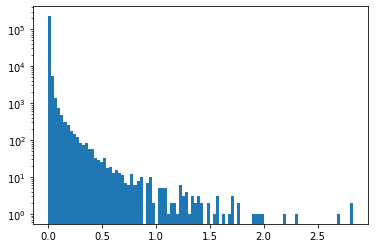

In [17]:
plt.hist(rse, bins=100)
plt.yscale('log')

In [18]:
p = 0.05

In [19]:
perc = np.percentile(rse, (1-p)*100)

In [20]:
perc

0.024885176924690954

In [21]:
m.verbose = 0

In [22]:
pred_targets = []
for xAR,yAR,target in tqdm_notebook(zip(x_AR_vectorized, y_AR_vectorized, targets), total=len(x_AR_vectorized)):
    yAR_approx = m.predict(xAR)
    rse = np.square(yAR_approx-yAR).sum(axis=1)
    pred_target = np.zeros(rse.shape[0], dtype=bool)
    pred_target[np.where(rse>=perc)] = True
    pred_target = np.concatenate([np.zeros(history_length, dtype=bool), pred_target])
    pred_targets.append(pred_target)

/tmp/ipykernel_9963/2881040192.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for xAR,yAR,target in tqdm_notebook(zip(x_AR_vectorized, y_AR_vectorized, targets), total=len(x_AR_vectorized)):


  0%|          | 0/40 [00:00<?, ?it/s]

In [23]:
pred_targets = np.concatenate(pred_targets)
pred_targets.shape

(234482,)

In [24]:
true_targets = np.concatenate(targets)
true_targets.shape

(234482,)

In [25]:
f1_score(true_targets, pred_targets)

0.33904130608236666

In [26]:
scores = []
for p in tqdm_notebook(np.linspace(0.001, 0.101, 101)):
    perc = np.percentile(rse, (1-p)*100)
    pred_targets = []
    for xAR,yAR,target in zip(x_AR_vectorized, y_AR_vectorized, targets):
        yAR_approx = m.predict(xAR)
        rse = np.square(yAR_approx-yAR).sum(axis=1)
        pred_target = np.zeros(rse.shape[0], dtype=bool)
        pred_target[np.where(rse>=perc)] = True
        pred_target = np.concatenate([np.zeros(history_length, dtype=bool), pred_target])
        pred_targets.append(pred_target)
    pred_targets = np.concatenate(pred_targets)
    true_targets = np.concatenate(targets)
    f1 = f1_score(true_targets, pred_targets)
    scores.append({'p': p, 'f1score': f1})

/tmp/ipykernel_9963/3748070729.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for p in tqdm_notebook(np.linspace(0.001, 0.101, 101)):


  0%|          | 0/101 [00:00<?, ?it/s]

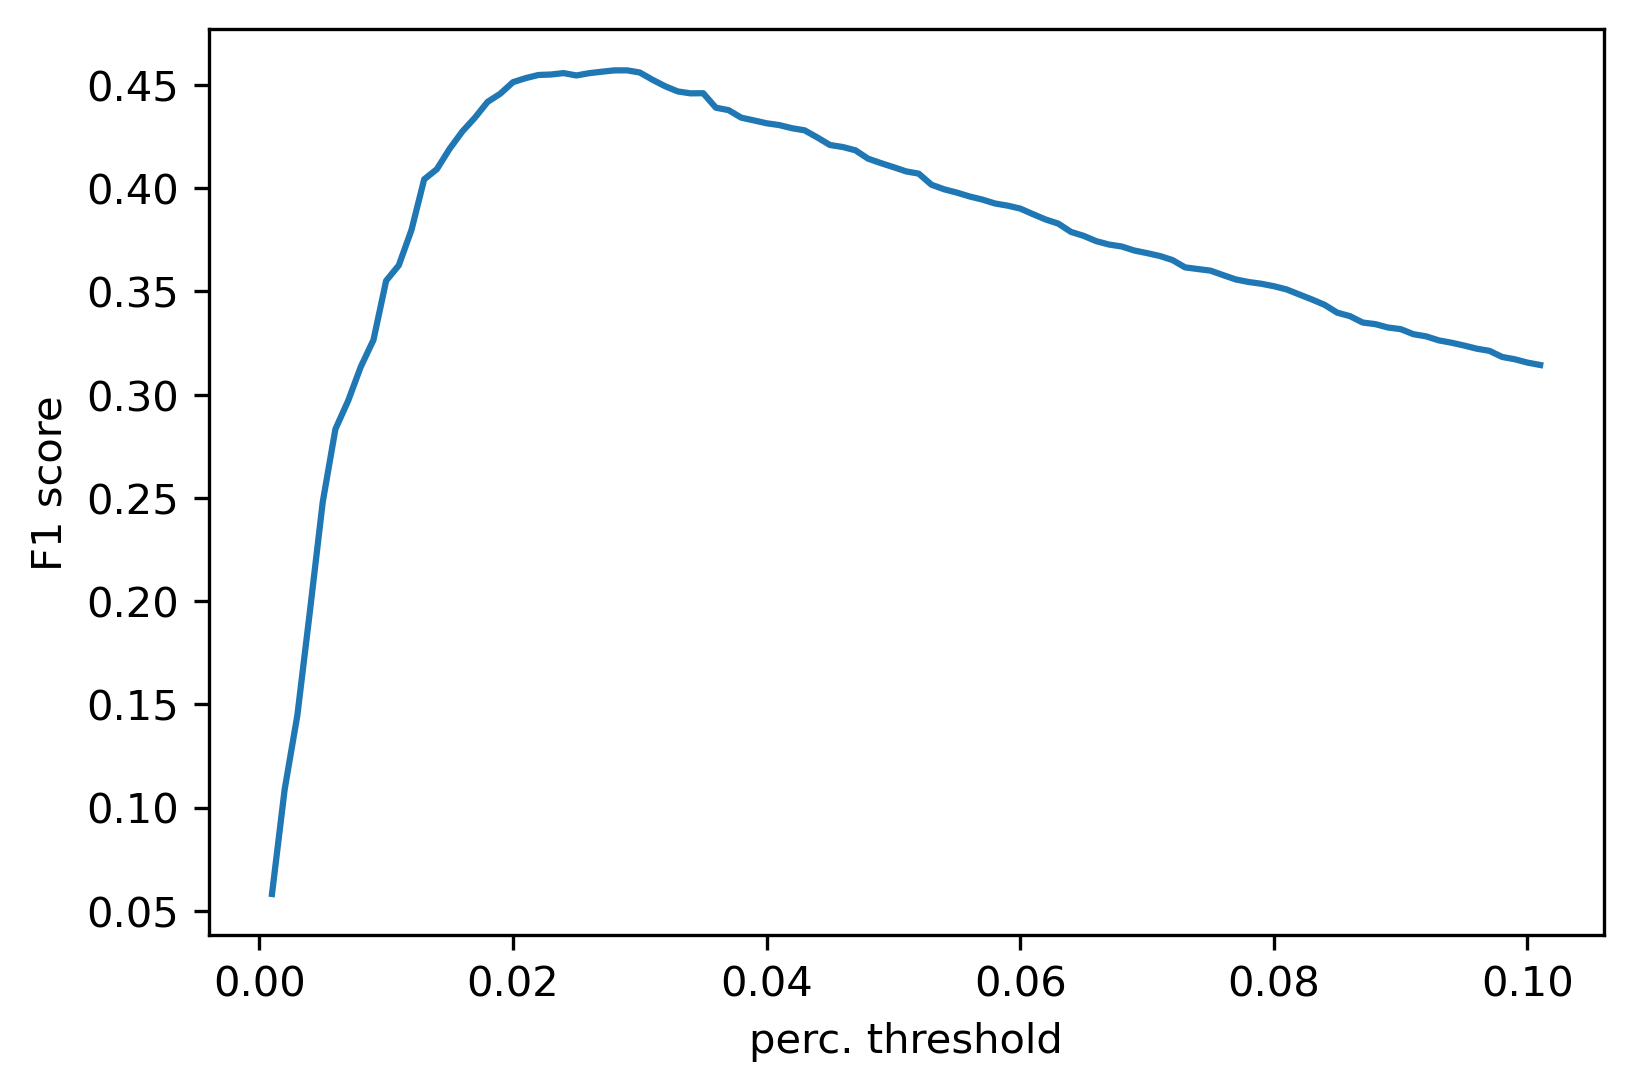

In [43]:
f = plt.figure(figsize=(6,4), dpi=300)
plt.plot([d['p'] for d in scores], [d['f1score'] for d in scores])
plt.xlabel('perc. threshold')
plt.ylabel('F1 score');

In [38]:
p_optim = [d['p'] for d in scores][np.argmax([d['f1score'] for d in scores])]
p_optim

0.029

In [39]:
rse_threshold = np.percentile(rse, (1-p_optim)*100)
rse_threshold

0.049350974276409956

In [40]:
[d['f1score'] for d in scores][np.argmax([d['f1score'] for d in scores])]

0.45710667932890153

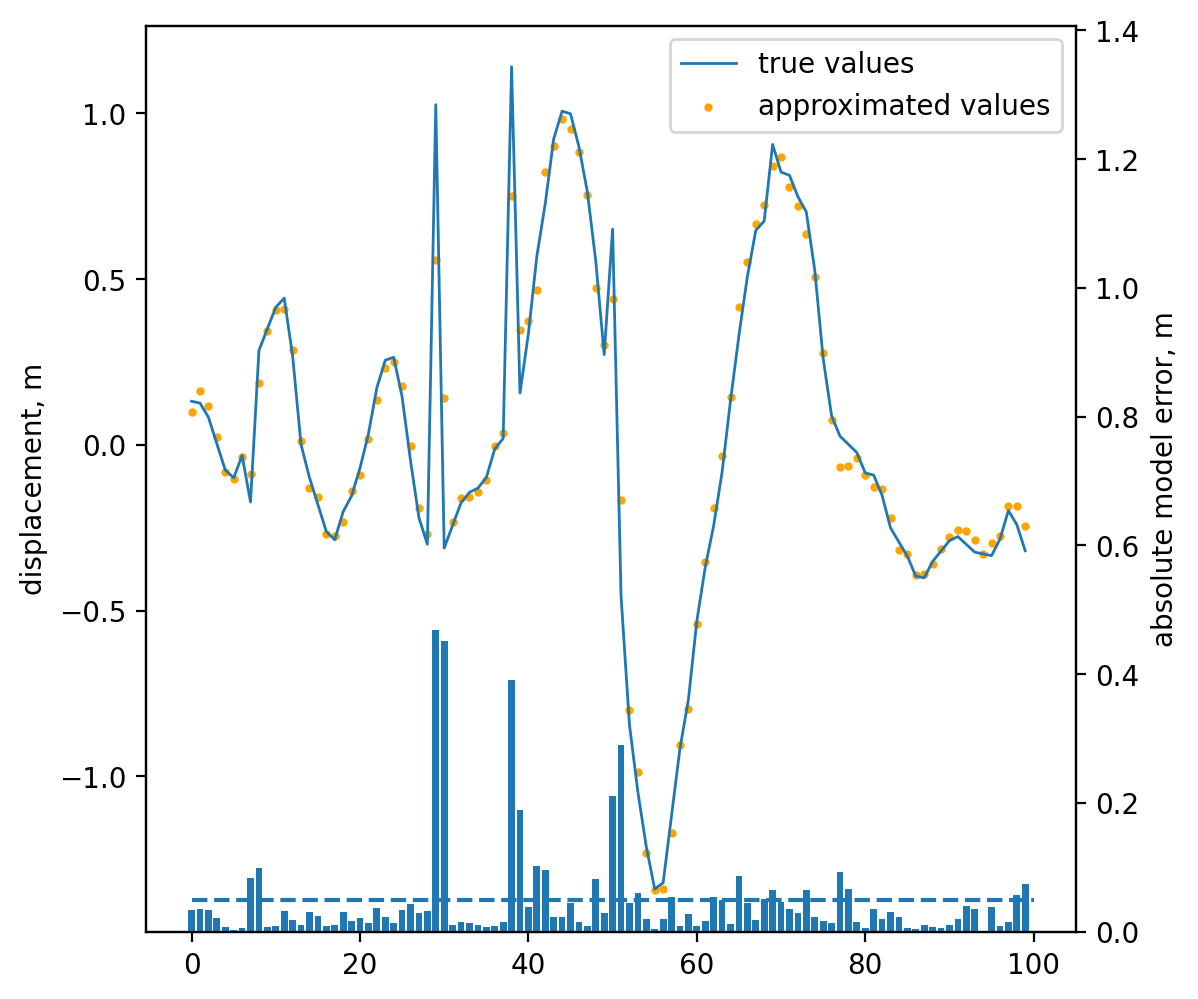

In [44]:
# item = np.random.randint(len(targets))
item=23
# start = np.random.randint(y_AR_vectorized[item].shape[0]-200)
start = 6090

f = plt.figure(figsize=(6,6), dpi=200)
plt.plot(np.arange(100),
         y_AR_vectorized[item][start:start+100, 1], linewidth=1, label='true values')
yAR_approx = m.predict(x_AR_vectorized[item])
plt.scatter(np.arange(100),
            yAR_approx[start:start+100, 1], s=4, c='orange',
            label='approximated values')
plt.ylabel('displacement, m')
plt.legend(fontsize=10, loc='upper right')

ax2 = plt.gca().twinx()
ax2.bar(np.arange(100), np.abs(yAR_approx[start:start+100, 1]-y_AR_vectorized[item][start:start+100, 1]))
ax2.set_ylim(0, np.abs(yAR_approx[start:start+100, 1]-y_AR_vectorized[item][start:start+100, 1]).max()*3)
ax2.set_ylabel('absolute model error, m')
ax2.hlines(rse_threshold, 0, 100, linestyles='dashed')

## Применим модель идентификации аномалий к тестовым данным

In [46]:
with open('./x_AR_vectorized_test.pkl', 'rb') as f:
    x_AR_vectorized_test = pickle.load(f)

In [47]:
with open('./y_AR_vectorized_test.pkl', 'rb') as f:
    y_AR_vectorized_test = pickle.load(f)

In [48]:
pred_targets_test = []
for xAR,yAR in tqdm_notebook(zip(x_AR_vectorized_test, y_AR_vectorized_test), total=len(x_AR_vectorized_test)):
    yAR_approx = m.predict(xAR)
    rse = np.square(yAR_approx-yAR).sum(axis=1)
    pred_target = np.zeros(rse.shape[0], dtype=bool)
    pred_target[np.where(rse >= rse_threshold)] = True
    pred_target = np.concatenate([np.zeros(history_length, dtype=bool), pred_target])
    pred_targets_test.append(pred_target)

/tmp/ipykernel_9963/4076270674.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for xAR,yAR in tqdm_notebook(zip(x_AR_vectorized_test, y_AR_vectorized_test), total=len(x_AR_vectorized_test)):


  0%|          | 0/20 [00:00<?, ?it/s]

In [49]:
pred_targets_test = np.concatenate(pred_targets_test)
pred_targets_test.shape

(136430,)

In [50]:
with open('./pred_targets_test_AR_RF.pkl', 'wb') as f:
    pickle.dump(pred_targets_test, f)